## Imports

In [1]:
import itertools as _it
if not hasattr(_it, "izip_longest"):
    _it.izip_longest = _it.zip_longest
import tracker
if not hasattr(tracker, "RunningMeanTorch"):
    class RunningMeanTorch:
        def __init__(self, *args, **kwargs):
            pass
    tracker.RunningMeanTorch = RunningMeanTorch

In [2]:
import os, sys
sys.path.append("..")
sys.path.append("../ALAE")
print(os.getcwd())
print(os.listdir())
import deeplake
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ALAE.alae_ffhq_inference import load_model, encode, decode
from notebooks_utils import TensorSampler

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import numpy as np
from matplotlib import pyplot as plt
import copy
import gc
import time
import ot as pot
import ot
from torch.serialization import safe_globals
from ALAE.model     import Model        
from ALAE.defaults  import get_cfg_defaults
from ALAE.checkpointer import Checkpointer
from ofmsrc.icnn import (
    LinActnormICNN,
    DenseICNN
)

import torchvision.utils as vutils
from torch import nn, autograd,Tensor
from typing import Optional, Tuple, Dict
from torch_fidelity import calculate_metrics
from torch.distributions import Categorical, MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from lib.act_func import Activations
from lib.hjbflow import ICNN1,ICNN3,evaluation_straight,compute_loss_back,compute_loss,train_flow_mnist,evaluation_mnist,sample_ode_hj,compute_loss_meanflow_v1

/home/sfh/ICNNFlow-new
['toy_test-Copy5.ipynb', 'train_hdbm-Copy2.ipynb', 'train_hdbm-0623.ipynb', 'train_hdbm-Copy6.ipynb', '__pycache__', 'lib', '.ipynb_checkpoints', 'results', 'toy_test-Copy2.ipynb', 'ofm_transfer_mb128.png', 'test_ALAE.ipynb', '8gaussiantest.ipynb', 'src', 'toy_test-Copy3.ipynb', 'notebooks_utils.py', 'toy_test-Copy4.ipynb', 'c-reflow_benchmark.ipynb', 'backup', 'train_hdbm-idp.ipynb', 'toy_test.ipynb', '.gitignore', 'creflow_bm.ipynb', 'data', 'infer_icnn_flow.py', 'train_hdbm-Copy4.ipynb', 'icnn_flow.py', 'reflow_benchmark-Copy1.ipynb', 'reflow_benchmark.ipynb', 'ALAE', 'W2_images.ipynb', 'train_ALAE.ipynb', 'ofmsrc', 'train_hdbm-Copy5.ipynb', '8gaussiantest-Copy1.ipynb', 'toy_test-Copy1.ipynb', 'train_mnist.ipynb', 'ALAE_AC.ipynb', 'notebook', 'generators2d.py', 'datasets', 'benchmarks', 'train_hdbm.ipynb', 'reflow_benchmark-Copy2.ipynb', 'largetest.ipynb']


In [3]:
log_dir = "./results/FFHQ"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "train.log"),
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)

## Results Plotting

In [4]:
torch.manual_seed(42)
np.random.seed(42)

# W2-ot
W2_METHOD      = "emd"  # "sinkhorn" 或 "emd"
SINKHORN_REG   = 5e-2
USE_SWD        = False      
SWD_PROJ       = 1024
SWD_SEED       = 1234

In [5]:
import os, numpy as np, torch
import matplotlib.pyplot as plt

FLOW_CKPT_PATH = "********"
ALAE_CKPT_PATH = "********"
FFHQ_CFG_PATH  = "../ALAE/configs/ffhq.yaml"
OUT_DIR        = log_dir
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def ensure_dataset():
    g = globals()
    need_load = any(k not in g for k in ["test_inp_images", "test_latents", "test_gender", "test_age"])
    if need_load:
        data_dir = "./data"
        print(f"[data] loading from {os.path.abspath(data_dir)}")
        g["test_inp_images"] = np.load(os.path.join(data_dir, "test_images.npy"))  # (N, H, W, 3)
        g["test_latents"]    = np.load(os.path.join(data_dir, "latents.npy"))      # (N, 512)
        g["test_gender"]     = np.load(os.path.join(data_dir, "gender.npy"))       # (N,)
        g["test_age"]        = np.load(os.path.join(data_dir, "age.npy"))          # (N,)
    print("test_images:", g["test_inp_images"].shape)
    print("test_latents:", g["test_latents"].shape)
    print("test_gender:", g["test_gender"].shape)

ensure_dataset()
cfg = get_cfg_defaults()
print( cfg.MODEL.LATENT_SPACE_SIZE)
cfg.merge_from_file(FFHQ_CFG_PATH); cfg.freeze()



print( cfg.MODEL.LATENT_SPACE_SIZE)

gen = Model(
    startf            = cfg.MODEL.START_CHANNEL_COUNT, #####important
    layer_count       = cfg.MODEL.LAYER_COUNT,
    maxf              = cfg.MODEL.MAX_CHANNEL_COUNT,
    latent_size       = cfg.MODEL.LATENT_SPACE_SIZE,
    dlatent_avg_beta  = cfg.MODEL.DLATENT_AVG_BETA,
    style_mixing_prob = cfg.MODEL.STYLE_MIXING_PROB,
    mapping_layers    = cfg.MODEL.MAPPING_LAYERS,
    channels          = cfg.MODEL.CHANNELS,
    generator         = cfg.MODEL.GENERATOR,
    encoder           = cfg.MODEL.ENCODER,
    z_regression      = cfg.MODEL.Z_REGRESSION
).to(device).eval()

ckpt_alae = torch.load(ALAE_CKPT_PATH, map_location=device, weights_only=False)
md = ckpt_alae["models"]
gen.mapping_f.load_state_dict(md["mapping_fl"], strict=False)
gen.decoder  .load_state_dict(md["generator"],  strict=False)
if "dlatent_avg" in md:
    try:
        gen.dlatent_avg.load_state_dict(md["dlatent_avg"], strict=False)
    except Exception:
        if isinstance(md["dlatent_avg"], dict) and "buff" in md["dlatent_avg"]:
            gen.dlatent_avg.buff.data.copy_(md["dlatent_avg"]["buff"])
        else:
            gen.dlatent_avg.buff.data.copy_(torch.tensor(md["dlatent_avg"], device=device))
else:
    print("[ALAE] WARNING: no dlatent_avg in checkpoint;")
    


ck_flow_meta = torch.load(FLOW_CKPT_PATH, map_location="cpu", weights_only=True)

hp = ck_flow_meta.get("hyperparams", {})
model_name = ck_flow_meta.get("model_name", "ICNN3")

ck_flow = torch.load(FLOW_CKPT_PATH, map_location=device, weights_only=True)
if "model_state" not in ck_flow:
    raise KeyError(f"[flow] ckpt:no 'model_state'，can use {list(ck_flow.keys())}")
state_dict_flow = ck_flow["model_state"]

if "Wxs.0.weight" not in state_dict_flow:
    raise KeyError("state_dict no 'Wxs.0.weight',print(state_dict_flow.keys()) ")

_w0 = state_dict_flow["Wxs.0.weight"].shape   
DIM  = _w0[1]                                 
dimh = hp.get("dimh", _w0[0])                  
num_hidl = hp.get("num_hidden_layers", 3)
act_name = hp.get("activation", "Softplus")
print(f"[flow] inferred DIM={DIM}, dimh={dimh}, num_hidl={num_hidl}, act={act_name}")

if model_name == "ICNN3":
    model = ICNN3(DIM, dimh=dimh, num_hidden_layers=10, act_fn=Activations.get_act('ssp')).to(device)
elif model_name == "ICNN1":
    model = ICNN3(DIM, dimh=dimh, num_hidden_layers=num_layers, act_fn=act_fn).to(device)
else:
    raise RuntimeError(f"no model: {model_name}")

try:
    missing_unexp = model.load_state_dict(state_dict_flow, strict=True)
    print("[flow] strict load ok:", missing_unexp)
except Exception as e:
    print(f"[flow] strict load failed：{e}\n")
    own = model.state_dict()
    filtered = {k: v for k, v in state_dict_flow.items() if k in own and v.shape == own[k].shape}
    msg = model.load_state_dict(filtered, strict=False)
    print("[flow] shape-compatible load:", msg)

start_iter = ck_flow.get("iteration", 0)
print(f"[flow] loaded from iter={start_iter}, loss_hist_len={len(ck_flow.get('loss_history', []))}")
model.eval()


[data] loading from /home/sfh/ICNNFlow-new/data
test_images: (300, 1024, 1024, 3)
test_latents: (70000, 512)
test_gender: (70000,)
256
512
[flow] inferred DIM=512, dimh=4096, num_hidl=10, act=<lambda>
[flow] strict load ok: <All keys matched successfully>
[flow] loaded from iter=54999, loss_hist_len=55000


ICNN3(
  (Wzs): ModuleList(
    (0-8): 9 x PosLinear2(in_features=4096, out_features=4096, bias=False)
    (9): PosLinear2(in_features=4096, out_features=1, bias=False)
  )
  (Wxs): ModuleList(
    (0-9): 10 x Linear(in_features=512, out_features=4096, bias=True)
    (10): Linear(in_features=512, out_features=1, bias=True)
  )
  (actnorms): ModuleList(
    (0-9): 10 x ActNormNoLogdet(4096)
    (10): ActNormNoLogdet(1)
  )
  (Snets): ModuleList(
    (0-9): 10 x Sequential(
      (0): Linear(in_features=1, out_features=4096, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=4096, out_features=4096, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=4096, out_features=4096, bias=True)
    )
    (10): Sequential(
      (0): Linear(in_features=1, out_features=4096, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=4096, out_features=4096, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=4096, out_features=1, bias=True)
    )
  )
  (rnet): Sequ

In [6]:
cfg.MODEL

CfgNode({'LAYER_COUNT': 9, 'START_CHANNEL_COUNT': 16, 'MAX_CHANNEL_COUNT': 512, 'LATENT_SPACE_SIZE': 512, 'DLATENT_AVG_BETA': 0.995, 'TRUNCATIOM_PSI': 0.7, 'TRUNCATIOM_CUTOFF': 8, 'STYLE_MIXING_PROB': 0.9, 'MAPPING_LAYERS': 8, 'CHANNELS': 3, 'GENERATOR': 'GeneratorDefault', 'ENCODER': 'EncoderDefault', 'MAPPING_D': 'MappingD', 'MAPPING_F': 'MappingF', 'Z_REGRESSION': False})

In [7]:
# 属性主成分
attr_names = ["gender","smile","attractive","wavy-hair","young","big lips","big nose","chubby","glasses"]
indices = [0,1,2,3,4,10,11,17,19]
dirs = []
for i in indices:
    d = torch.tensor(np.load(f"ALAE/principal_directions/direction_{i}.npy"), dtype=torch.float32, device=device)
    d = d / (d.norm() + 1e-8)
    dirs.append(d)
D_attr = torch.stack(dirs, dim=0)   # [9, 512]

def project_gender_multi(delta, D_attr, allow_indices=[0,3,4,11], scales=[1.0, 1.8, 1.3,5]):
    # 先去掉不在allow_indices中的方向分量
    for j in range(D_attr.size(0)):
        if j not in allow_indices:
            b = D_attr[j].to(delta.device)
            coeff = (delta * b).sum(dim=-1, keepdim=True)
            delta = delta - coeff * b
    result = torch.zeros_like(delta)
    for idx, scale in zip(allow_indices, scales):
        b = D_attr[idx].to(delta.device)
        coeff = (delta * b).sum(dim=-1, keepdim=True) * scale
        result += coeff * b
    return result

def decode_from_centered_W(gen, w_centered):
    L = gen.mapping_f.num_layers
    w_full = w_centered + gen.dlatent_avg.buff.data[0].to(w_centered.device)
    w_stack = w_full[:, None, :].repeat(1, L, 1)
    lod = len(gen.decoder.decode_block) - 1
    img = gen.decoder(w_stack, lod=lod, blend=1.0, noise=False).clamp(-1, 1)
    return (img + 1) / 2

def align_latents(latents, N_img):
    if len(latents) == N_img:
        print("[info] latents with 300 ")
        return latents
    elif "x_inds_test" in globals() and len(x_inds_test) == N_img:
        print("[info] 用 x_inds_test 将 latents 对齐到测试集")
        return latents[np.array(x_inds_test)]
    elif len(latents) >= 60000 + N_img:
        print("[info] 使用 latents[60000:60000+N] 对齐到测试集")
        return latents[60000 : 60000 + N_img]
    else:
        raise RuntimeError(f"无法对齐 latents（len(latents)={len(latents)}, N_img={N_img}）")

def _get_w_avg(g):
    for owner in [g, getattr(g, "mapping_f", None)]:
        if owner is None: continue
        for key in ["dlatent_avg", "w_avg"]:
            val = getattr(owner, key, None)
            if val is None: continue
            buff = getattr(val, "buff", None)
            if buff is not None:
                return buff.data[0]
            if torch.is_tensor(val):
                return val
    raise RuntimeError("No w_avg（dlatent_avg/w_avg）")

def decode_from_centered_W(g, w_centered, lod=None, blend=1.0, noise=False):
    with torch.no_grad():
        device = next(g.parameters()).device
        L = getattr(g.mapping_f, "num_layers", 18)
        w_full  = w_centered + _get_w_avg(g).to(device)
        w_stack = w_full[:, None, :].expand(-1, L, -1).contiguous()
        # if lod is None:
        #     if hasattr(g, "decoder") and hasattr(g.decoder, "decode_block"):
        #         lod = len(g.decoder.decode_block) - 1
        #     else:
        #         raise RuntimeError("无法确定 lod")
        img = g.decoder(w_stack, lod=lod, blend=blend, noise=noise).clamp(-1, 1)
        return (img + 1) / 2

# def show_triplet_grid(real_imgs, gen1,  save_path=None, figsize=(6, 10)): ###纵向
#     real_imgs = real_imgs.clamp(0,1).cpu()
#     gen1 = gen1.clamp(0,1).cpu()
#     rows = [torch.cat([real_imgs[i], gen1[i]], dim=2) for i in range(real_imgs.size(0))]
#     grid = torch.cat(rows, dim=1)
#     plt.figure(figsize=figsize); plt.axis("off")
#     plt.imshow(grid.permute(1,2,0).numpy())
#     if save_path:
#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#         plt.savefig(save_path, bbox_inches="tight")
#     plt.show()

def show_triplet_grid(real_imgs, gen1, save_path=None, figsize=(10, 6)):
# def show_triplet_grid(gen1, save_path=None, figsize=(10, 6)):

    real = real_imgs.clamp(0, 1).cpu()
    gen  = gen1.clamp(0, 1).cpu()
    B, C, H, W = real.shape
    assert gen.shape == real.shape
    # 横向拼接一整行：real 行与 gen 行
    row_real = torch.cat([real[i] for i in range(B)], dim=2) if B > 0 else torch.zeros(C, H, 0)
    row_gen  = torch.cat([gen[i]  for i in range(B)], dim=2) if B > 0 else torch.zeros(C, H, 0)


    grid = torch.cat([row_real, row_gen], dim=1)  # (C, 2H, Wmax)
    #grid = torch.cat([row_gen], dim=1)  # (C, 2H, Wmax)


    plt.figure(figsize=figsize); plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).numpy())
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def gender_mask(arr, target="male"):
    arr = np.array(arr)
    if arr.dtype.kind in ("U","S","O"):
        s = arr.astype(str)
        return (s == target)
    u = sorted(set(arr.tolist()))
    if u == [-1,1]:
        return (arr==1) if target=="male" else (arr==-1)
    if u == [0,1]:
        return (arr==1) if target=="male" else (arr==0)
    return np.ones_like(arr, dtype=bool)


In [8]:
#### W2 need
def emd_w2(A: np.ndarray, B: np.ndarray, dtype=np.float32) -> float:
    A = np.asarray(A, dtype=dtype, order="C")
    B = np.asarray(B, dtype=dtype, order="C")
    na, nb = len(A), len(B)
    a = np.full(na, 1.0/na, dtype=dtype)
    b = np.full(nb, 1.0/nb, dtype=dtype)
    # cost metrics
    C = ot.dist(A, B, metric="euclidean")**2
    C = C.astype(dtype, copy=False)
    cost = ot.emd2(a, b, C)  
    return float(math.sqrt(max(cost, 0.0)))
    
def pairwise_sqeuclidean(X, Y, batch=1024):
    N, D = X.shape; M, D2 = Y.shape
    assert D == D2
    out = np.empty((N, M), dtype=np.float64)
    for i in range(0, N, batch):
        Xi = X[i:i+batch]
        Xi2 = (Xi**2).sum(axis=1, keepdims=True)
        Y2  = (Y**2).sum(axis=1, keepdims=True).T
        XY  = Xi @ Y.T
        out[i:i+batch] = Xi2 + Y2 - 2.0 * XY
    np.maximum(out, 0.0, out=out)
    return out

def compute_w2(real_feats, gen_feats, method=W2_METHOD, reg=SINKHORN_REG,
               use_swd=USE_SWD, swd_proj=SWD_PROJ, swd_seed=SWD_SEED):
    if use_swd:
        from ot.sliced import sliced_wasserstein_distance
        w2 = sliced_wasserstein_distance(real_feats, gen_feats,
                                         n_projections=swd_proj, seed=swd_seed)
        return {"w2": float(w2), "detail": {"mode": "swd", "n_projections": swd_proj}}

    N, M = real_feats.shape[0], gen_feats.shape[0]
    a = np.ones((N,), dtype=np.float64) / N
    b = np.ones((M,), dtype=np.float64) / M
    Mmat = pairwise_sqeuclidean(real_feats, gen_feats)

    if method == "emd":
        w2 = ot.emd2(a, b, Mmat)
        return {"w2": float(w2), "detail": {"mode": "emd"}}
    elif method == "sinkhorn":
        w2, log = ot.sinkhorn2(a, b, Mmat, reg=reg, log=True)
        return {"w2": float(w2), "detail": {"mode": "sinkhorn", "reg": reg, "n_iter": log.get('niter', None)}}
    else:
        raise ValueError("method must be 'emd' or 'sinkhorn'")

N_img: 300
[info] 使用 latents[60000:60000+N] 对齐到测试集
[indices] [135, 207, 97, 299, 210, 252, 8, 60, 284, 262, 178, 298]
[gender]  ['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male']
(x, t)
[Loaded] latents: shape=(12, 512), dtype=float32
[EMD· f#Z_0, Z_1] : 16.569331
[EMDours f#Z_0, Z_0] : 10.881948
[costours f#Z_0, Z_0] : 10.853341


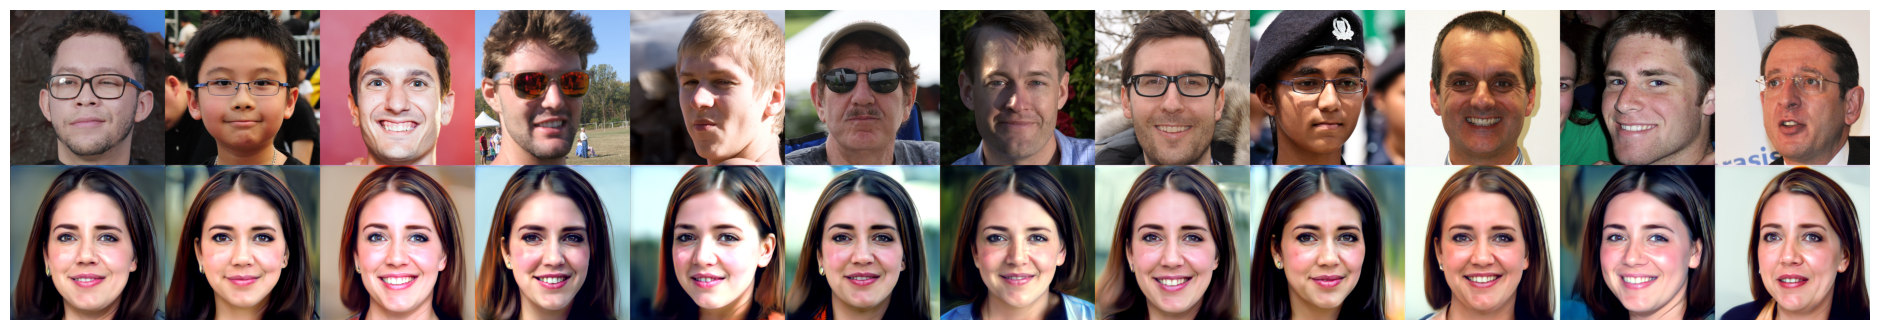

[saved]：./results/FFHQ/1023nosp/vis/2_fixed1.png


In [14]:
# MAN--WOMAN

# torch.manual_seed(42)
# np.random.seed(42)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(0)
gen.eval()
device = next(gen.parameters()).device

N_img = len(test_inp_images)
print("N_img:", N_img)   
if "test_gender300" not in globals():
    if ("test_gender" in globals()) and (len(test_gender) >= 60000 + N_img):
        test_gender300 = np.array(test_gender[60000 : 60000 + N_img])  
    else:
        raise RuntimeError("No test_gender300")


latents_aligned = align_latents(test_latents, N_img)

MODE = "fixed"     # "fixed" 或 "by_gender"
INPUT_GENDER = "male"
N_SHOW = 12
steps  = 1

# 120, 90, 46, 67, 268, 124, 151, 235,
# 173, 60,213, 62, 145, 8, 228, 208, 
# 182, 41, 274, 23, 291, 153, 107, 0, 
# 25, 95, 115, 58, 148, 262,195, 37,
# 166, 51, 98, 146, 215, 66, 143, 285, 
# 17, 147, 59, 270, 64, 298, 156, 87, 

# [169, 268, 74, 22, 252, 193, 144, 40, 182, 285, 156, 95]
# [135, 207, 97, 299, 210, 252, 8, 60, 284, 262, 178, 298]


if MODE == "fixed":
    inds = np.array([135, 207, 97, 299, 210, 252, 8, 60, 284, 262, 178, 298])
else:
    mask = gender_mask(test_gender300, INPUT_GENDER)
    valid = np.where(mask)[0]
    assert len(valid) >= N_SHOW, f"{INPUT_GENDER}"
    inds = np.random.choice(valid, size=N_SHOW, replace=False)

print("[indices]", inds.tolist())
def to_gender_str(vec):
    v = np.array(vec)
    if v.dtype.kind in ("U","S","O"): return v.astype(str)
    u = sorted(set(v.tolist()))
    if u in ([0,1], [-1,1]):
        return np.where((v==1), "male", "female")
    return v.astype(str)
print("[gender] ", to_gender_str(test_gender300[inds]).tolist())
import inspect
print(inspect.signature(model.forward))

real_imgs = torch.tensor(test_inp_images[inds]).permute(0,3,1,2).float()/255.0
W0 = torch.tensor(latents_aligned[inds]).float().to(device)
W_gen1 = sample_ode_hj(W0, model, t0=0.0, N=steps, return_path=False)
LOD = len(gen.decoder.decode_block) - 1
with torch.no_grad():
    img_gen1 = decode_from_centered_W(gen, W_gen1, lod=LOD, noise=False)
    


fz0 = (W_gen1).detach().float().cpu().numpy()
z0 = (W0[:3000]).detach().float().cpu().numpy()
mask1 = (test_gender=='female')
inds_all1 = np.where(mask1)[0]
inds1 = inds_all1[:3000]
Z1=  torch.tensor(test_latents[inds1]).float()
z1 = (Z1[:3000]).detach().float().cpu().numpy()
#mean_bias = fz0.mean(axis=0)-z1.mean(axis=0)
print(f"[Loaded] latents: shape={fz0.shape}, dtype={fz0.dtype}")
res1 = emd_w2(fz0,z1) # f#Z_0, Z_1
res3 = emd_w2(fz0,z0) # f#Z_0, Z_0
res4 = np.mean(np.sum((fz0-z0)**2,axis=1)**(0.5))
print(f"[EMD· f#Z_0, Z_1] : {res1:.6f}")
#print(f"[EMD· Z_0, Z_1] : {res2:.6f}")
print(f"[EMDours f#Z_0, Z_0] : {res3:.6f}")
print(f"[costours f#Z_0, Z_0] : {res4:.6f}")


save_dir  = os.path.join(OUT_DIR if 'OUT_DIR' in globals() else os.getcwd(), "vis")
save_path = os.path.join(save_dir, f"2_{MODE}{steps}.png")
show_triplet_grid(real_imgs, img_gen1,save_path=save_path, figsize=(2*len(inds),6))
print(f"[saved]：{save_path}")
